## MITgcm data
## MITgcm model
## local normed


In [1]:
import sys 
sys.path.append('../modules/')

In [2]:
%reload_ext autoreload
%autoreload 2
import evaluation

2024-03-06 20:02:22.388436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 20:02:22.388468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 20:02:22.388475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
model_nc  = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/MITgcm_all_window_1_local_norm_true.nc'
data_kind = 'MITgcm' 
M2LInES_bucket= 'gs://leap-persistent/dhruvbalwada/m2lines_transfer'

exp_name  = '' 
ML_name   = 'all'

In [5]:
eval_dic = {}
Lkeys = ['50', '100', '200', '400']
for L in Lkeys: 
    #data_zarr = 'gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_'+L+'km_3D'
    eval_dic[L] = evaluation.full_reader(model_nc, M2LInES_bucket, 
                                  L, data_kind, 
                                  exp_name,
                                  ML_name='all',
                                  Tdim='time',
                                  local_norm=True)
    

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_200km_3D
Centered
Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_400km_3D
Centered


In [6]:
import matplotlib.pyplot as plt
import numpy as np

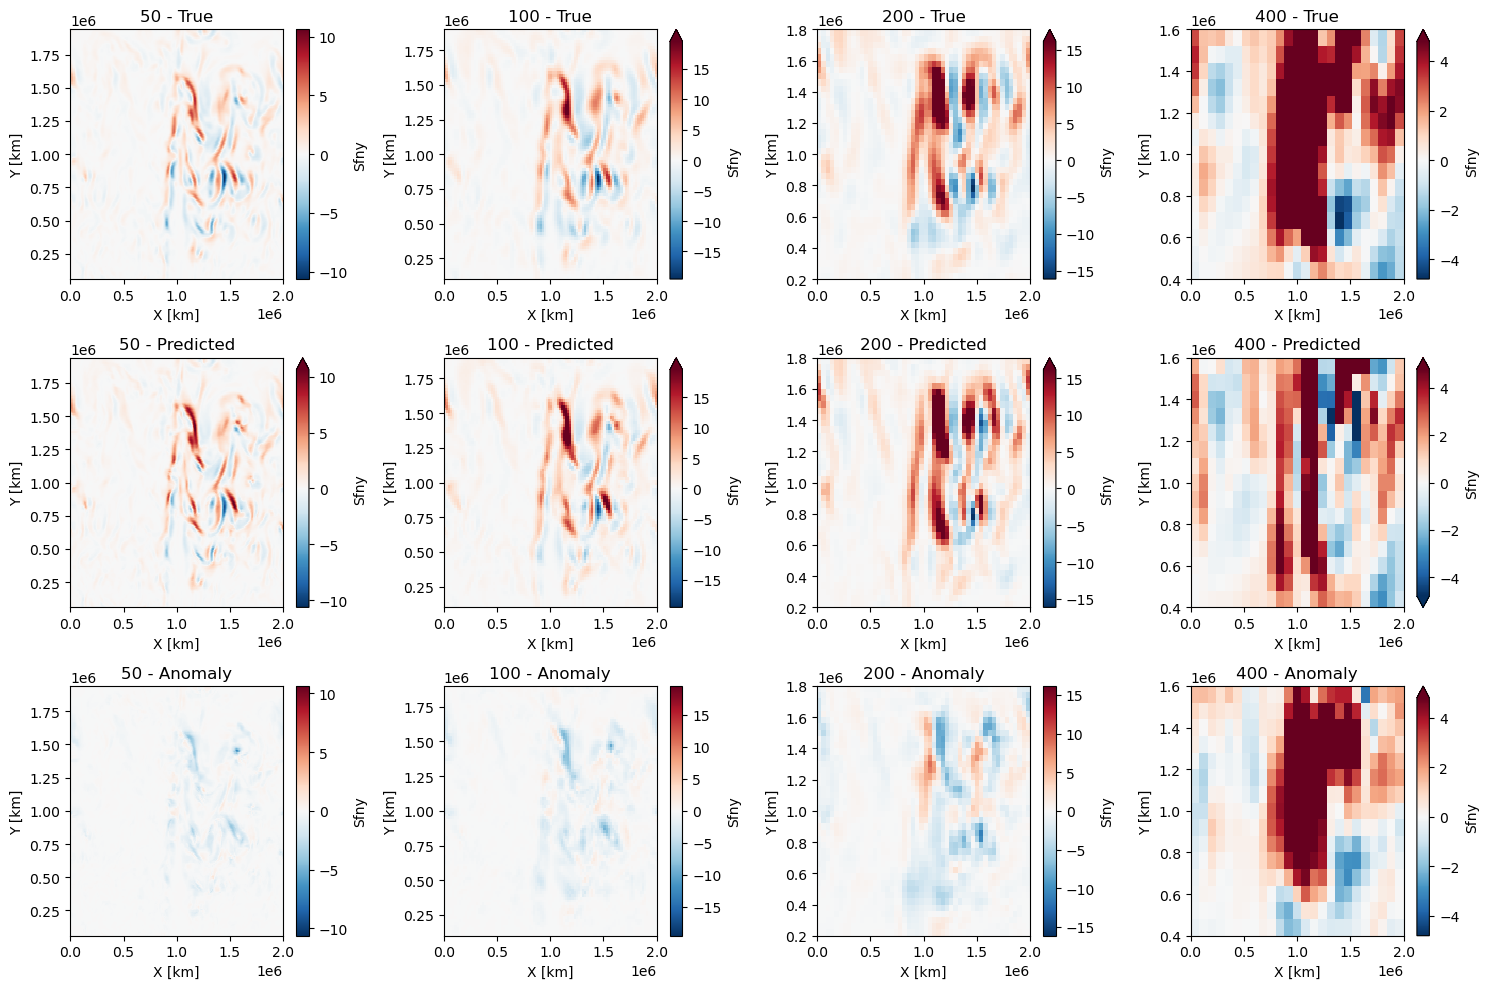

In [7]:
# Create a figure and axis objects
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Iterate through the keys '50km', '100km', '200km', and '400km' and plot each dataset
for i, key in enumerate(['50', '100', '200', '400']):
    values = eval_dic[key]
    ds_true = values.output_ds.Sfny.isel(time=-1, Z=10)
    ds_pred = values.output_pred_ds.Sfny.isel(time=-1, Z=10)
    ds_anomaly = ds_true - ds_pred

    # Plotting true values
    ds_true.plot(ax=axs[0,i], vmin=ds_true.min().values)
    axs[0,i].set_title(f'{key} - True')
    
    # Plotting predicted values
    ds_pred.plot(ax=axs[1,i], vmin=ds_true.min().values)
    axs[1,i].set_title(f'{key} - Predicted')
    
    # Plotting anomaly values
    ds_anomaly.plot(ax=axs[2,i], vmin=ds_true.min().values)
    axs[2,i].set_title(f'{key} - Anomaly')
    
    # Set title and labels
    for j in range(3):
        axs[j,i].set_xlabel('X [km]')
        axs[j,i].set_ylabel('Y [km]')

    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
#plt.show()

#plt.savefig('./figures/data_MOM6p2l_ML_MITgcm_all_panels.png')

## Metrics:

### Pointwise

In [8]:
Lkeys = ['50', '100', '200', '400']
print('R2:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_R2(dims=['time','XC','YC','Z']).values) )

R2:
50: 0.9438022
100: 0.9104783
200: 0.85541415
400: 0.74315906


In [9]:

Lkeys = ['50', '100', '200', '400']
print('Corr:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_corr(dims=['time','XC','YC','Z']).values) )

Corr:
50: 0.973626
100: 0.9571164
200: 0.9253106
400: 0.866209


### Spectral 

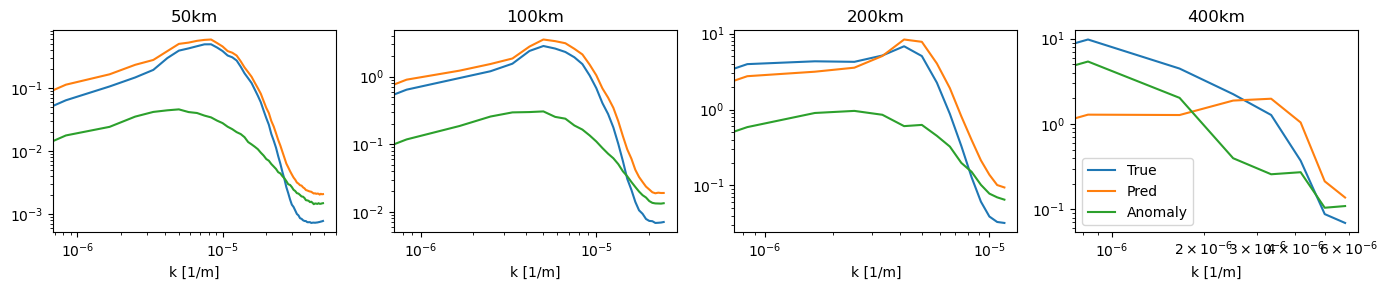

In [10]:
plt.figure(figsize=(14, 3)) 

for i,L in enumerate(Lkeys): 
    true_ps, pred_ps, anom_ps = eval_dic[L].zonal_PS_MITgcm(var='Sfny', 
                                                     avg_dims=['time','YC'])
    plt.subplot(1,4,i+1)
    (true_ps.isel(Z=10) * true_ps.freq_XC).plot(label='True')
    (pred_ps.isel(Z=10) * pred_ps.freq_XC).plot(label='Pred')
    (anom_ps.isel(Z=10) * anom_ps.freq_XC).plot(label='Anomaly')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k [1/m]')
    plt.title(L+'km')

plt.tight_layout()
plt.legend()

#plt.savefig('./figures/data_MOM6p2l_ML_MITgcmall_spectra.png')